In [744]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [745]:
np.random.seed(42)

# Pricing Bermudan (American-ish) Options via Least–Squares Monte Carlo

This document describes in detail how to implement the **Longstaff–Schwartz** (2001) algorithm for pricing a Bermudan option (a discretely exercisable American option) using Python. We will:

---

## 1. Problem Setup

- We have exercise dates  
  $$
    0 = t_0 < t_1 < t_2 < \cdots < t_N = T\,.
  $$
- On each date $t_i$ the (undiscounted) payoff of immediate exercise is  
  $$
    F_{t_i} = h\bigl(S_{t_i}\bigr),
  $$
  e.g.\ for a put option $h(S) = \max(K - S,0)$.
- We work under the risk-neutral measure $\mathbb{Q}$. Let  
  $$
    D_{t_i,t_j} = \exp\bigl(-\!\int_{t_i}^{t_j} r(s)\,ds \bigr)
  $$
  be the stochastic discount factor.

The continuation value at time $t_i$ is
$$
  C_{t_i} \;=\; 
  \mathbb{E}^\mathbb{Q}\bigl[D_{t_i,t_{i+1}}\,V_{t_{i+1}}\mid \mathcal{F}_{t_i}\bigr],
$$
(note that we wish to find a good regression for the estimate of this continuation value) where 
$$
  V_{t_{i+1}} \;=\; \max\bigl(F_{t_{i+1}},\,C_{t_{i+1}}\bigr).
$$
The Longstaff–Schwartz algorithm replaces this conditional expectation by a least-squares regression on simulated paths.

---

## 2. Longstaff–Schwartz Algorithm (Backward Induction)

1. **Simulate** $M$ paths of the underlying price $S_{t_i}^{(m)}$, $i=0,\dots,N$, under $\mathbb{Q}$.  
2. **Initialize** cash-flows at maturity:  
   $$
     X_{t_N}^{(m)} = F_{t_N}^{(m)},\quad m=1,\dots,M.
   $$
3. **Backward induction** for $i = N-1,\,N-2,\,\dots,1$:
   a. For each path $m$, collect the in-the-money subset $\{m : F_{t_i}^{(m)}>0\}$.  
   b. Regress the *discounted* continuation values  
      $$
        Y^{(m)} = D_{t_i,t_{i+1}}\;X_{t_{i+1}}^{(m)}
      $$
      against basis functions of the state $S_{t_i}^{(m)}$, e.g.\ polynomials $\{1,\,S,\,S^2\}$.  
   c. Denote the fitted regression by $\widehat C_{t_i}(S)$.  
   d. **Exercise decision**:  
      $$
        X_{t_i}^{(m)}
        = 
        \begin{cases}
          F_{t_i}^{(m)}, &\text{if }F_{t_i}^{(m)} \ge \widehat C_{t_i}\bigl(S_{t_i}^{(m)}\bigr),\\[6pt]
          D_{t_i,t_{i+1}}\;X_{t_{i+1}}^{(m)}, &\text{otherwise.}
        \end{cases}
      $$
4. **Price** at $t=0$ is estimated by the discounted expectation of $X_{t_1}$:
   $$
     \widehat V_0 
     = \frac{1}{M}\sum_{m=1}^M D_{0,t_1}\;X_{t_1}^{(m)}.
   $$

In [746]:
def blackscholes_mc(ts, n_paths, S0, vol, r, q):
    """Generate Monte-Carlo paths in Black-Scholes model.

    Parameters
    ----------
    ts: array_like
        The time steps of the simualtion
    n_paths: int
        the number of paths to simulate
    S0: scalar
        The spot price of the underlying security.
    vol: scalar
        The implied Black-Scholes volatility.
    r: scalar
        The annualized risk-free interest rate, continuously compounded.
    q: scalar
        The annualized continuous dividend yield.

    Returns
    -------
    paths: ndarray
        The Monte-Carlo paths.
    """
    paths = np.full((len(ts), n_paths), np.nan, dtype=float)
    paths[0] = S0
    for i in range(len(ts)-1):
        dt = ts[i+1] - ts[i]
        dW = np.sqrt(dt)*np.random.randn(n_paths)
        paths[i+1] = paths[i] * np.exp((r-q-1/2*vol**2)*dt + vol*dW)
    return paths

In [ ]:
S0 = 223.78 #change this on monday
K = 180
vol = 0.24
r = 0.05
q = 0.02

T = 4/12 #change this on monday

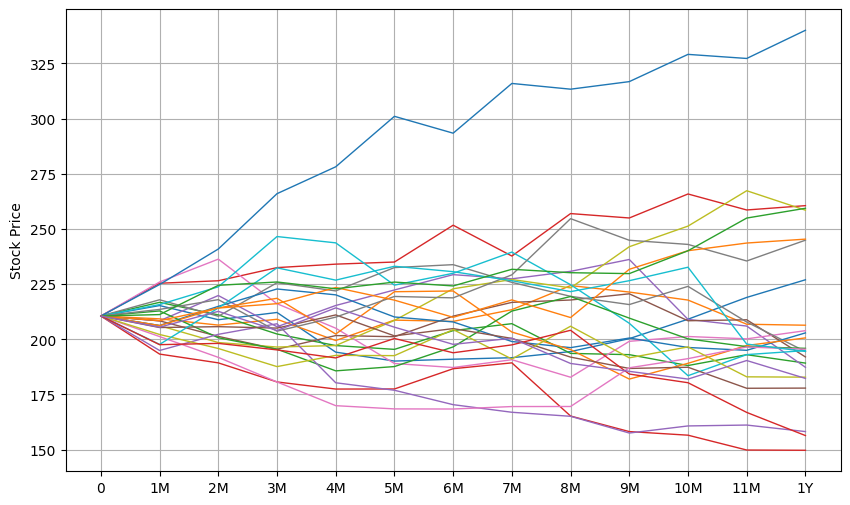

In [748]:
ts = np.linspace(0, T, 13) #change this on monday
n_paths = 10000
paths = blackscholes_mc(ts, n_paths, S0, vol, r, q) # generates Monte Carlo Paths for the stock price

#Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ts, paths[:, :25], lw=1)
ax.set_xticks(ts)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '1Y'])
ax.set_ylabel('Stock Price')
ax.grid(True)

^^^ I tried tweaking the np.linspace to make it np.linspace(0,1,1000) and the program takes longer to run. why is that?

### Price of European put option

In [749]:
np.mean(np.maximum(K-paths[-1], 0))*np.exp(-r*T)

#averaging payoffs of put option at each month

np.float64(2.0457843278945966)

#### Longstaff-Schwartz algorithm

We use polynomials as basis functions for demonstration purposes.

In [750]:
payoff = np.maximum(K-paths[-1], 0)
for i in range(len(ts)-2, 0, -1):
    discount = np.exp(-r*(ts[i+1]-ts[i]))
    payoff = payoff*discount

    # THE REGRESSION IS DONE HERE -- here, we are simply using polynomial regression 
    # (recall the other methods from ConditionalExpectation.ipynb)
    p = np.polyfit(paths[i], payoff, deg=2)
    contval = np.polyval(p, paths[i])
    exerval = np.maximum(K-paths[i], 0)
    # identify the paths where we should exercise
    ind = exerval > contval
    payoff[ind] = exerval[ind]
np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))

np.float64(1.8545331246556234)

For your reference, the price of the Bermudan option is $5.152$. In the exercise below, try to see if you can get close to this value (will be helpful for our project later on)

# **Longstaff–Schwartz** Regression Method

We now adapt both the **Longstaff–Schwartz** (LS) algorithm to use three different regression methods:

  1. **Black–Scholes basis**: $\{1,\;P_{\rm BS}(S_{t},K,r,\bar\sigma,\tau)\}$  
     where $P_{\rm BS}$ is the European‐put formula with volatility $\bar\sigma=0.2$ and remaining time $\tau=T-t$.  
  2. **Piecewise‐linear regression** with $J$ knots. (Try different values of $J$)
  3. **Kernel (Nadaraya–Watson)** regression with a Gaussian kernel and bandwidth $h$. (Try different values of $h$).

We first set up our simulation and then define:
- A **Black–Scholes European Pricer** function (GIVEN BELOW),
- (**Task 1**) A **pricers** (`ls_pricer`) that estimates the CONTINUATION VALUE to decide whether or not you will exercise on a certain date.

In [751]:
def blackscholes_price(K, T, S0, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S0: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S0*np.exp((r-q)*T)
    v = vol*np.sqrt(T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')

np.float64(1.5342604771222823)

In [752]:
# import numpy as np

# def pwlin_design(x, k):
#     return np.column_stack([np.ones_like(x), x - k[0]] + [np.maximum(x - a, 0.0) for a in k])

# def gauss_kern(u):
#     return np.exp(-0.5 * u**2)

# def kern_reg(x, xdata, ydata, h):
#     w = gauss_kern((xdata[:, None] - x) / h)
#     return (w * ydata[:, None]).sum(0) / w.sum(0)

# def ls_pricer(ts, paths, K, r, q, method='bs', J=0, h=5.0, vol_bar=0.2):
#     T = ts[-1]
#     payoff = np.maximum(K - paths[-1], 0.0)

#     sq_error = 0.0
#     n_obs = 0

#     for i in range(len(ts) - 2, 0, -1):
#         dt = ts[i + 1] - ts[i]
#         payoff = payoff * np.exp(-r * dt)

#         S = paths[i]
#         ex = np.maximum(K - S, 0.0)
#         itm = ex > 0

#         if method == 'bs':
#             tau = T - ts[i]
#             bsi = blackscholes_price(K, tau, S[itm], vol_bar, r, q, 'put')
#             B = np.column_stack([np.ones_like(bsi), bsi])
#             beta = np.linalg.lstsq(B, payoff[itm], rcond=None)[0]
#             all_bs = blackscholes_price(K, tau, S, vol_bar, r, q, 'put')
#             cont = beta[0] + beta[1] * all_bs

#         elif method == 'pwlin':
#             k = np.linspace(np.percentile(S[itm], 2.5), np.percentile(S[itm], 97.5), J)
#             beta = np.linalg.lstsq(pwlin_design(S[itm], k), payoff[itm], rcond=None)[0]
#             cont = pwlin_design(S, k) @ beta

#         elif method == 'kernel':
#             cont = np.zeros_like(S)
#             cont[itm] = kern_reg(S[itm], S[itm], payoff[itm], h)

#         cont_itm = cont[itm]
#         diff = cont_itm - payoff[itm]
#         sq_error += np.sum(diff**2)
#         n_obs += diff.size

#         payoff[ex > cont] = ex[ex > cont]

#     mse = sq_error / n_obs if n_obs > 0 else np.nan
#     print("LS regression MSE (method = %s):" % method, mse)

#     return np.mean(payoff * np.exp(-r * (ts[1] - ts[0])))


# price_bs = ls_pricer(ts, paths, K, r, q, method='bs', vol_bar=0.2)
# price_pw = ls_pricer(ts, paths, K, r, q, method='pwlin', J=4000) #CHANGE J HERE
# price_kn = ls_pricer(ts, paths, K, r, q, method='kernel', h=5.0)
# print("-" * 50)
# print('LS price (Black Scholes):', price_bs)
# print('LS price (Piecewise-Linear regression):', price_pw)
# print('LS price (Naradya - Watson Kernel):', price_kn)

///
#### Real price: 5.152
///

Matthew's comments: It seems that the Black Scholes model and the Kernel (NW) regression create a continuation value that is more similar to the actual price of the american put option. I'm not so sure why this is the case but I did expect the BS model to be somewhat close since after doing so many monte carlo simulation paths the avg payoffs should be close to the price. [NOT SURE THO].

For piecewise linear regression (Continuation Value):

1 knot: 3.195

5 knots: 3.084

10 knots: 3.078

15 knots: 2.820

20 knots: 2.858

- *(I don't think small values is enough to capture the non-linearity of the option)*

...

1000 knots: 4.2878 (Just like Sam's one in Whatsapp) | MSE: 36.7629

2000 knots: 4.7915 | MSE: 29.5231

3000 knots: 5.1072 | MSE: 22.3256

4000 knots: 5.3115 | MSE: 16.9015

* *takes 2 min 51 sec to run*

10000 knots: 5.74714 | MSE: [NOT CALCULATED]

///

The Longstaff-Schwartz algorithm provide an estimate for the expected payoff from continuation at each exercise date from the cross-sectional information in the simulation using regression. By comparing this estimate with the immediate exercise value, the holder of the option can determine whether to exercise the option or continue. 

**(Task 2)** Perform an independent Monte Carlo simulation using this estimate of continuation value from LS algorithm as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound. Try different methods for regression and compare the results.

Show your code and result with at least 100000 simulations.

In [753]:
def train_ls_policy(ts, paths, K, r, q, vol_bar, method='bs', J=0, h=5.0, ):
    T = ts[-1]
    payoff = np.maximum(K - paths[-1], 0.0)
    policy = [None] * len(ts)

    sq_error = 0.0
    n_obs = 0

    for i in range(len(ts) - 2, 0, -1):
        dt = ts[i + 1] - ts[i]
        payoff = payoff * np.exp(-r * dt)

        S = paths[i]
        ex = np.maximum(K - S, 0.0)
        itm = ex > 0

        if not np.any(itm):
            policy[i] = {'method': method, 'kind': 'none'}
            continue

        if method == 'bs':
            tau = T - ts[i]
            bsi = blackscholes_price(K, tau, S[itm], vol_bar, r, q, 'put')
            X = np.column_stack([np.ones_like(bsi), bsi])
            beta = np.linalg.lstsq(X, payoff[itm], rcond=None)[0]
            policy[i] = {'method': 'bs', 'beta': beta}
            all_bs = blackscholes_price(K, tau, S, vol_bar, r, q, 'put')
            cont = beta[0] + beta[1] * all_bs

        # elif method == 'pwlin':
        #     k = np.linspace(np.percentile(S[itm], 2.5),
        #                     np.percentile(S[itm], 97.5), J)
        #     X_itm = pwlin_design(S[itm], k)
        #     beta = np.linalg.lstsq(X_itm, payoff[itm], rcond=None)[0]
        #     policy[i] = {'method': 'pwlin', 'beta': beta, 'k': k}
        #     cont = pwlin_design(S, k) @ beta

        # elif method == 'kernel':
        #     policy[i] = {
        #         'method': 'kernel',
        #         'S_itm': S[itm].copy(),
        #         'y_itm': payoff[itm].copy(),
        #         'h': h
        #     }
        #     cont = np.zeros_like(S)
        #     cont[itm] = kern_reg(S[itm], S[itm], payoff[itm], h)

        # accumulate training MSE on in-the-money points
        cont_itm = cont[itm]
        diff = cont_itm - payoff[itm]
        sq_error += np.sum(diff**2)
        n_obs += diff.size

        payoff[ex > cont] = ex[ex > cont]
        

    dt0 = ts[1] - ts[0]
    disc_payoffs = payoff * np.exp(-r * dt0)
    train_price = disc_payoffs.mean()

    # 95% CI for the Monte Carlo estimator
    std = disc_payoffs.std(ddof=1)
    se = std / np.sqrt(disc_payoffs.size)
    ci_low = train_price - 1.96 * se
    ci_high = train_price + 1.96 * se



    mse = sq_error / n_obs if n_obs > 0 else np.nan
    return policy, train_price, mse, ci_low, ci_high


In [754]:
def apply_ls_policy(ts, paths, K, r, q, policy, vol_bar, method='bs'):
    T = ts[-1]
    n_paths = paths.shape[1]

    exercised = np.zeros(n_paths, dtype=bool)
    exercise_payoffs = np.zeros(n_paths)
    exercise_times = np.zeros(n_paths)

    for i in range(1, len(ts)):
        S = paths[i]
        ex = np.maximum(K - S, 0.0)

        active = ~exercised
        active_idx = np.where(active)[0]
        if active_idx.size == 0:
            break

        if i == len(ts) - 1:
            ex_now = ex[active]
            mask = ex_now > 0
            chosen = active_idx[mask]
            exercise_payoffs[chosen] = ex_now[mask]
            exercise_times[chosen] = ts[i]
            exercised[chosen] = True
        else:
            info = policy[i]
            if info is None or info.get('kind') == 'none':
                continue

            if method == 'bs':
                tau = T - ts[i]
                bs_vals = blackscholes_price(K, tau, S[active],
                                             vol_bar, r, q, 'put')
                beta = info['beta']
                cont = beta[0] + beta[1] * bs_vals

            # elif method == 'pwlin':
            #     k = info['k']
            #     beta = info['beta']
            #     X = pwlin_design(S[active], k)
            #     cont = X @ beta

            # elif method == 'kernel':
            #     S_train = info['S_itm']
            #     y_train = info['y_itm']
            #     h = info['h']
            #     cont = kern_reg(S[active], S_train, y_train, h)

            ex_now = ex[active]
            mask = ex_now > cont
            chosen = active_idx[mask]

            exercise_payoffs[chosen] = ex_now[mask]
            exercise_times[chosen] = ts[i]
            exercised[chosen] = True

    discount = np.exp(-r * exercise_times)
    disc_payoffs = exercise_payoffs * discount
    price = disc_payoffs.mean()

    # 95% CI for the lower bound
    std = disc_payoffs.std(ddof=1)
    se = std / np.sqrt(disc_payoffs.size)
    ci_low = price - 1.96 * se
    ci_high = price + 1.96 * se

    return price, ci_low, ci_high


In [755]:
# Training and test Monte Carlo simulations
n_train = 20000
n_test = 100000

train_paths = blackscholes_mc(ts, n_train, S0, vol, r, q)
test_paths = blackscholes_mc(ts, n_test, S0, vol, r, q)

# Black-Scholes basis
policy_bs, train_price_bs, mse, ci_low_train, ci_high_train = train_ls_policy(
    ts, train_paths, K, r, q,
    method='bs', vol_bar=vol
)
lower_bs, ci_low_test, ci_high_test = apply_ls_policy(
    ts, test_paths, K, r, q,
    policy_bs, method='bs', vol_bar=vol
)

# # Piecewise-linear regression
# policy_pw, train_price_pw, mse = train_ls_policy(
#     ts, train_paths, K, r, q,
#     method='pwlin', J=1000
# )
# lower_pw = apply_ls_policy(
#     ts, test_paths, K, r, q,
#     policy_pw, method='pwlin'
# )

# #kernel regression
# def kernel_regression():
#     n_train = 2000
#     n_test = 10000

#     train_paths = blackscholes_mc(ts, n_train, S0, vol, r, q)
#     test_paths = blackscholes_mc(ts, n_test, S0, vol, r, q)

#     policy_kn, train_price_kn, mse = train_ls_policy(
#         ts, train_paths, K, r, q,
#         method='kernel', h=5.0
#     )
#     lower_kn = apply_ls_policy(
#         ts, test_paths, K, r, q,
#         policy_kn, method='kernel'
#     )

#     return train_price_kn, lower_kn

print("Training LS prices (20000 paths):")
print("  Black scholes basis: ", train_price_bs)
print(f"Training confidence interval (95%): [{ci_low_train:.4f}, {ci_high_train:.4f}]")

# print("  Piecewise-linear:", train_price_pw)

print("\nLower-bound prices (out-of-sample, 100000 paths):")
print("  Black scholes basis: ", lower_bs)
print(f"Lower-bound confidence interval (95%): [{ci_low_test:.4f}, {ci_high_test:.4f}]")

# print("  Piecewise-linear: ", lower_pw)


print("-" * 50)
print("-" * 50)

# # Separate Kernel Regression
# train_price_kn, lower_kn = kernel_regression()
# print("Training LS price (2000 paths):")
# print("  Kernel regression :", train_price_kn)

# print("\nLower-bound prices (out-of-sample, 10000 paths):")
# print("  Kernel regression :", lower_kn)


Training LS prices (20000 paths):
  Black scholes basis:  0.971692567462556
Training confidence interval (95%): [0.9092, 1.0341]

Lower-bound prices (out-of-sample, 100000 paths):
  Black scholes basis:  1.0074548811402544
Lower-bound confidence interval (95%): [0.9794, 1.0355]
--------------------------------------------------
--------------------------------------------------


### Problem: The code takes EXTREMELY long to run under 20000 train and 100000 test.

I identified the problem: It's the kernel regression. It takes a VERY long time to run and I can't seem to get a hold of the issue.

### Findings:

Piecewise Linear regression heavily overfits the data inside LS_pricer and gives a value that's more close to the actual price. But when we train and test it using new sample paths, it gets cooked and the price is not very close to the actual price. (I'm not sure why...)

Black scholes basis seems to be consistent and works even using out-of-sample data

Kernele regression also seems to be consistent and doesn't seem to overfit the data that much

To add:

What if I do train test for 30 times, and create a confidence interval for the lower bound prices based on that?

